ERROR:root:Lỗi khi xử lý trang 121: HTTPSConnectionPool(host='monngonmoingay.com', port=443): Read timed out. (read timeout=10)
ERROR:root:Lỗi khi xử lý trang 122: HTTPSConnectionPool(host='monngonmoingay.com', port=443): Read timed out. (read timeout=10)
ERROR:root:Lỗi khi xử lý trang 123: HTTPSConnectionPool(host='monngonmoingay.com', port=443): Read timed out. (read timeout=10)
ERROR:root:Lỗi khi xử lý trang 124: HTTPSConnectionPool(host='monngonmoingay.com', port=443): Read timed out. (read timeout=10)
ERROR:root:Lỗi khi xử lý trang 125: HTTPSConnectionPool(host='monngonmoingay.com', port=443): Read timed out. (read timeout=10)
ERROR:root:Lỗi khi xử lý trang 126: HTTPSConnectionPool(host='monngonmoingay.com', port=443): Read timed out. (read timeout=10)
ERROR:root:Lỗi khi xử lý trang 127: HTTPSConnectionPool(host='monngonmoingay.com', port=443): Read timed out. (read timeout=10)
ERROR:root:Lỗi khi xử lý trang 128: HTTPSConnectionPool(host='monngonmoingay.com', port=443): Read timed

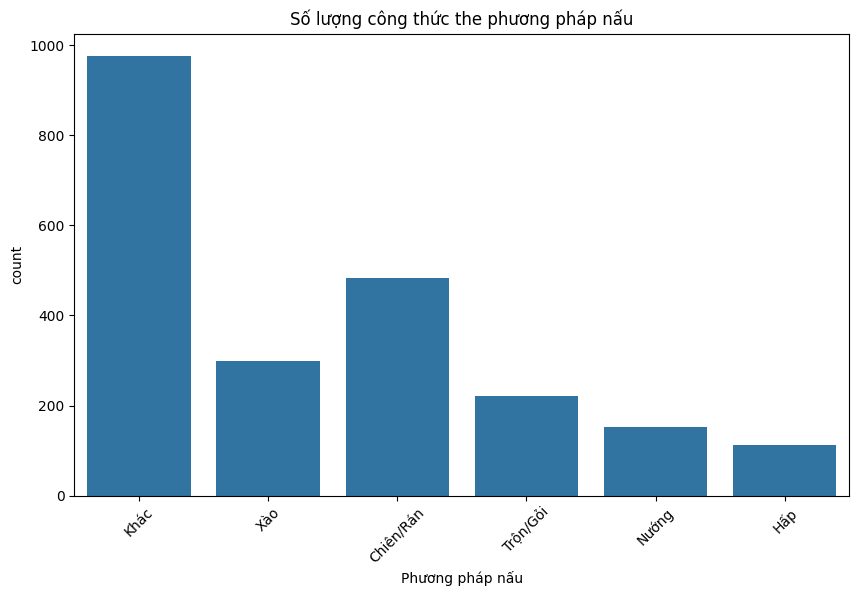

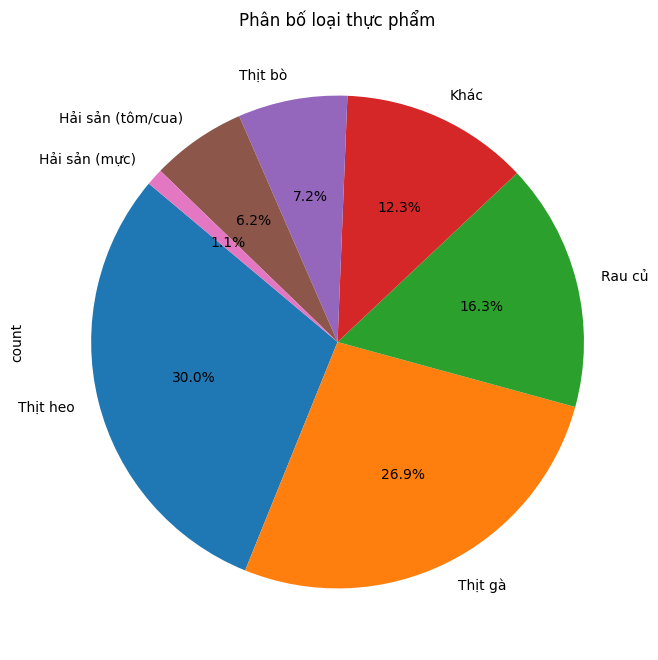

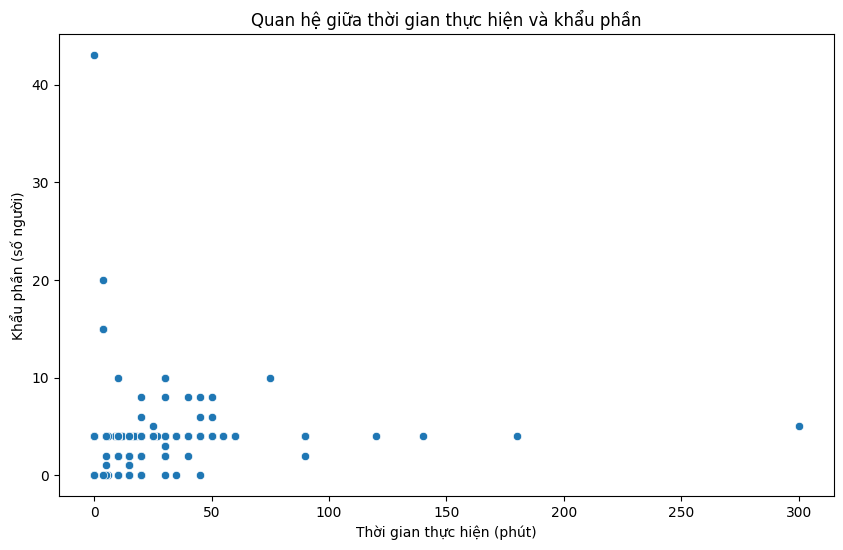

In [ ]:
# Cài đặt các thư viện cần thiết
# !pip install requests beautifulsoup4 pandas openpyxl tqdm numpy

import requests
from bs4 import BeautifulSoup
import logging
import time
from urllib.parse import urlparse
from datetime import datetime
import pandas as pd
import concurrent.futures
from tqdm import tqdm
import re
import numpy as np


In [ ]:

# Thiết lập logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler('webscraper.log'),
        logging.StreamHandler()
    ]
)
logger = logging.getLogger()

# Thiết lập session và headers để giả lập trình duyệt
session = requests.Session()
session.headers.update({
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36',
    'Accept-Language': 'vi-VN,vi;q=0.9,en-US;q=0.8,en;q=0.7',
    'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8',
    'Connection': 'keep-alive',
    'Upgrade-Insecure-Requests': '1',
})


In [ ]:

# =============================================================================
# PHẦN I: SCRAPING - Giữ nguyên logic lấy URL, ảnh và trích xuất chi tiết
# =============================================================================
def get_recipe_info(max_pages=10):
    """
    Lấy danh sách các công thức kèm theo link ảnh từ trang tìm kiếm.
    Trả về danh sách dict với key 'URL' và 'Image'.
    """
    recipe_info_list = []

    for page in range(1, max_pages + 1):
        url = f"https://monngonmoingay.com/tim-kiem-mon-ngon/page/{page}/"
        try:
            response = session.get(url, timeout=10)
            response.encoding = 'utf-8'

            if response.status_code != 200:
                logger.warning(f"Không thể truy cập trang {page}. Mã trạng thái: {response.status_code}.")
                break

            soup = BeautifulSoup(response.text, 'html.parser')
            recipe_cards = soup.find_all("div", class_=re.compile("flex-recipe"))

            if not recipe_cards:
                logger.info(f"Không tìm thấy card công thức nào trên trang {page}.")
                break

            for card in recipe_cards:
                detail_link = card.find("a", title="Xem chi tiết")
                if detail_link and detail_link.get("href"):
                    recipe_url = detail_link.get("href")
                    image_url = ""
                    a_with_img = card.find("a", href=recipe_url)
                    if a_with_img:
                        img_tag = a_with_img.find("img")
                        if img_tag and img_tag.get("src"):
                            image_url = img_tag.get("src")
                    recipe_info_list.append({
                        "URL": recipe_url,
                        "Image": image_url
                    })

            logger.info(f"Trang {page}: Thu thập được {len(recipe_cards)} công thức.")
            time.sleep(2 + (page % 3) * 0.5)

        except Exception as e:
            logger.error(f"Lỗi khi xử lý trang {page}: {e}")
            continue

    logger.info(f"Tổng số công thức thu thập được: {len(recipe_info_list)}")
    return recipe_info_list

def format_ingredients(soup):
    """
    Định dạng nguyên liệu với dấu phẩy ngăn cách.
    """
    ingredients = []
    ingredient_blocks = soup.select('#section-nguyenlieu .block-nguyenlieu')

    if not ingredient_blocks:
        ingredient_section = soup.find('div', id='section-nguyenlieu')
        if ingredient_section:
            ingredients += [li.get_text(strip=True) for li in ingredient_section.find_all('li')]
            ingredients += [a.text.strip() for a in ingredient_section.select('a.giavi')]
    else:
        for block in ingredient_blocks:
            ingredients += [li.get_text(strip=True) for li in block.find_all('li')]
            ingredients += [a.text.strip() for a in block.select('a.giavi')]

    ingredients = [item.strip() for item in ingredients if item.strip()]
    return ", ".join(ingredients) if ingredients else "Không tìm thấy"

def sanitize_text(text):
    """
    Sanitize text by removing illegal characters and normalizing whitespace.
    Use this for any text extracted from the website.
    """
    if not isinstance(text, str):
        return text

    # Remove control characters
    text = re.sub(r'[\x00-\x08\x0B-\x0C\x0E-\x1F\x7F]', '', text)

    # Normalize whitespace
    text = ' '.join(text.split())

    return text

def extract_recipe_details(recipe):
    """
    Trích xuất thông tin chi tiết của công thức từ URL và thêm link ảnh.
    Bao gồm sanitize_text để loại bỏ ký tự không hợp lệ.
    """
    url = recipe.get("URL")
    image_url = recipe.get("Image", "")

    try:
        response = session.get(url, timeout=15)
        response.encoding = 'utf-8'
        response.raise_for_status()
        soup = BeautifulSoup(response.text, 'html.parser')

        def get_clean_text(element):
            if not element:
                return "Không tìm thấy thông tin"
            if element.name == 'div' and element.find_all('p'):
                text = '\n'.join([p.get_text(strip=True) for p in element.find_all('p') if p.get_text(strip=True)])
                return sanitize_text(text)
            text = element.get_text(separator='\n', strip=True)
            return sanitize_text(text)

        title = soup.find('h1')
        title_text = sanitize_text(title.text.strip()) if title else "Không tìm thấy tiêu đề"

        ingredients_text = format_ingredients(soup)
        ingredients_text = sanitize_text(ingredients_text)

        preparation_section = soup.find('div', id='section-soche')
        preparation = "Không tìm thấy"
        if preparation_section:
            preparation_div = preparation_section.find('div', class_='ewa-rteLine') or preparation_section.find('div')
            preparation = get_clean_text(preparation_div)

        execution_section = soup.find('div', id='section-thuchien')
        execution = "Không tìm thấy"
        if execution_section:
            execution_div = execution_section.find('div', class_='ewa-rteLine') or execution_section.find('div')
            execution = get_clean_text(execution_div)

        usage_section = soup.find('div', id='section-howtouse')
        usage = "Không tìm thấy"
        if usage_section:
            usage_div = usage_section.find('div', class_='ewa-rteLine') or usage_section.find('div')
            usage = get_clean_text(usage_div)

        tips_section = soup.find('div', id='section-tips')
        tips = []
        if tips_section:
            tips_divs = tips_section.find_all('div', class_='ewa-rteLine') or tips_section.find_all('div')
            tips = [sanitize_text(div.get_text(strip=True)) for div in tips_divs if div.get_text(strip=True)]
        tips_text = ", ".join(tips) if tips else "Không tìm thấy"

        menu_text = ""
        menu_table = soup.find('table')
        if menu_table:
            rows = menu_table.find_all('tr')
            for row in rows:
                cells = [sanitize_text(cell.get_text(strip=True)) for cell in row.find_all(['td', 'th'])]
                menu_text += " | ".join(cells) + "\n"
        if not menu_text:
            menu_text = "Không tìm thấy"
        else:
            menu_text = sanitize_text(menu_text)

        advice_text = ""
        advice_heading = None
        for heading in soup.find_all(['h3', 'h4']):
            if heading and ('LỜI KHUYÊN' in heading.text.upper() or 'CHUYÊN GIA DINH DƯỠNG' in heading.text.upper()):
                advice_heading = heading
                break
        if advice_heading:
            current = advice_heading.next_sibling
            while current and (not getattr(current, 'name', None) in ['h3', 'h4']):
                if hasattr(current, 'text'):
                    text = sanitize_text(current.get_text(strip=True))
                    if text:
                        advice_text += text + "\n"
                current = current.next_sibling
        if not advice_text:
            advice_section = None
            for div in soup.find_all('div', class_='flex flex-col gap-4'):
                h4 = div.find('h4')
                if h4 and ('LỜI KHUYÊN' in h4.text.upper() or 'CHUYÊN GIA DINH DƯỠNG' in h4.text.upper()):
                    advice_section = div
                    break
            if advice_section:
                advice_divs = advice_section.find_all('div', class_='ewa-rteLine')
                if advice_divs:
                    for div in advice_divs:
                        advice_text += sanitize_text(div.text.strip()) + "\n"
        if not advice_text:
            advice_text = "Không tìm thấy"
        else:
            advice_text = sanitize_text(advice_text)

        description = ""
        description_section = soup.select_one('ul.section-tabs + div')
        if description_section:
            description = description_section.get_text(separator=' ', strip=True)
            description = sanitize_text(description)
        else:
            description = "Không tìm thấy"

        info_divs = soup.find_all('div', class_='flex flex-col gap-1 text-sm items-center')
        khau_phan = "Không tìm thấy"
        thoi_gian_thuc_hien = "Không tìm thấy"
        do_kho = "Không tìm thấy"
        for div in info_divs:
            span = div.find('span', class_='text-xs')
            if span:
                label = span.text.strip()
                strong = div.find('strong')
                if strong:
                    value = sanitize_text(strong.text.strip())
                    if 'Khẩu Phần' in label:
                        khau_phan = value
                    elif 'Thời gian thực hiện' in label:
                        thoi_gian_thuc_hien = value
                    elif 'Độ khó' in label:
                        do_kho = value

        nutrition_div = soup.find('div', class_='w-full flex flex-col gap-2 justify-start')
        nutrition = "Không tìm thấy"
        if nutrition_div:
            strong = nutrition_div.find('strong')
            if strong:
                nutrition = sanitize_text(strong.text.strip())

        categories = "Không tìm thấy"
        script_tags = soup.find_all('script')
        for script in script_tags:
            if 'window.dataLayer.push' in script.text:
                match = re.search(r"'categories':\s*'([^']+)'", script.text)
                if match:
                    categories_raw = match.group(1)
                    categories = sanitize_text(categories_raw.replace(' | ', ', '))
                    break

        recipe_data = {
            'URL': url,
            'Image': image_url,
            'Tiêu đề': title_text,
            'Description': description,
            'Khẩu phần': khau_phan,
            'Thời gian thực hiện': thoi_gian_thuc_hien,
            'Độ khó': do_kho,
            'Dinh dưỡng': nutrition,
            'Categories': categories,
            'Nguyên liệu': ingredients_text,
            'Sơ chế': preparation,
            'Thực hiện': execution,
            'Cách dùng': usage,
            'Mách nhỏ': tips_text,
            'Thực đơn': menu_text.strip(),
            'Lời khuyên chuyên gia': advice_text.strip()
        }

        return recipe_data

    except Exception as e:
        logger.error(f"Lỗi khi trích xuất thông tin từ {url}: {e}")
        return {
            'URL': url,
            'Image': image_url,
            'Tiêu đề': "Lỗi khi trích xuất",
            'Description': "",
            'Khẩu phần': "",
            'Thời gian thực hiện': "",
            'Độ khó': "",
            'Dinh dưỡng': "",
            'Categories': "",
            'Nguyên liệu': f"Lỗi: {str(e)}",
            'Sơ chế': "",
            'Thực hiện': "",
            'Cách dùng': "",
            'Mách nhỏ': "",
            'Thực đơn': "",
            'Lời khuyên chuyên gia': ""
        }

def process_batch(recipes_batch):
    """
    Xử lý một batch các công thức để cải thiện hiệu suất.
    """
    results = []
    for recipe in recipes_batch:
        results.append(extract_recipe_details(recipe))
        time.sleep(1.5 + (hash(recipe.get("URL", "")) % 5) * 0.3)
    return results


In [ ]:

# =============================================================================
# PHẦN II: TIỀN XỬ LÝ & LÀM SẠCH (DATA CLEANING)
# =============================================================================
def clean_excel_data(df):
    """
    Clean dataframe values to remove illegal characters for Excel.
    This prevents IllegalCharacterError when saving to Excel.
    """
    # Define a function to clean individual strings
    def clean_string(s):
        if not isinstance(s, str):
            return s

        # Remove or replace control characters that Excel doesn't allow
        return re.sub(r'[\x00-\x08\x0B-\x0C\x0E-\x1F\x7F]', '', s)

    # Apply the cleaning function to all string columns
    for col in df.select_dtypes(include=['object']).columns:
        df[col] = df[col].apply(clean_string)

    return df
def clean_dataframe(df):
    """
    Tiền xử lý và làm sạch DataFrame:
    1. Loại bỏ dòng trùng lặp (theo URL)
    2. Điền giá trị rỗng ban đầu bằng "Không tìm thấy"
    3. Chuẩn hóa khoảng trắng hoặc ký tự đặc biệt
    4. Chuyển 'Khẩu phần' từ '4 người' -> '4'
    5. Chuyển 'Thời gian thực hiện' từ '35 Phút' -> '35'
    6. Chuyển 'Dinh dưỡng' từ '120 kcal/người' -> 120
    """
    df.drop_duplicates(subset='URL', inplace=True)
    df.fillna("Không tìm thấy", inplace=True)

    # Chuẩn hóa khoảng trắng
    for col in ['Tiêu đề', 'Description']:
        df[col] = df[col].apply(lambda x: ' '.join(x.split()) if isinstance(x, str) else x)

    # Trích xuất số từ 'Khẩu phần'
    def parse_portion(portion_text):
        match = re.search(r'(\d+)', portion_text)
        return match.group(1) if match else None

    df['Khẩu phần (số)'] = df['Khẩu phần'].apply(parse_portion)

    # Trích xuất số từ 'Thời gian thực hiện'
    def parse_time(time_text):
        match = re.search(r'(\d+)', time_text)
        return match.group(1) if match else None

    df['Thời gian (phút)'] = df['Thời gian thực hiện'].apply(parse_time)

    # Trích xuất số từ 'Dinh dưỡng'
    def parse_nutrition(nutrition_text):
        if nutrition_text == "Không tìm thấy":
            return None
        match = re.search(r'(\d+)', nutrition_text)
        return match.group(1) if match else None

    df['Dinh dưỡng (kcal)'] = df['Dinh dưỡng'].apply(parse_nutrition)

    return df


In [ ]:

# =============================================================================
# PHẦN III: PHÂN LOẠI & TRÍCH XUẤT TAG (TAG EXTRACTION)
# =============================================================================
def extract_tags(df):
    """
    Gán tag dựa trên từ khóa:
    - 'Phương pháp nấu': chiên, nướng, hấp, xào, trộn...
    - 'Loại thực phẩm': thịt gà, thịt bò, hải sản, rau...
    """
    df['Phương pháp nấu'] = None
    df['Loại thực phẩm'] = None

    for idx, row in df.iterrows():
        title = row['Tiêu đề'].lower()
        categories = row['Categories'].lower() if row['Categories'] else ""
        ingredients = row['Nguyên liệu'].lower()

        if any(kw in title for kw in ['chiên', 'rán']) or 'chiên' in categories:
            df.at[idx, 'Phương pháp nấu'] = 'Chiên/Rán'
        elif any(kw in title for kw in ['nướng']) or 'nướng' in categories:
            df.at[idx, 'Phương pháp nấu'] = 'Nướng'
        elif any(kw in title for kw in ['hấp']) or 'hấp' in categories:
            df.at[idx, 'Phương pháp nấu'] = 'Hấp'
        elif any(kw in title for kw in ['xào']) or 'xào' in categories:
            df.at[idx, 'Phương pháp nấu'] = 'Xào'
        elif any(kw in title for kw in ['salad', 'trộn', 'gỏi']) or 'gỏi/trộn' in categories:
            df.at[idx, 'Phương pháp nấu'] = 'Trộn/Gỏi'

        if any(meat in ingredients for meat in ['gà', 'thịt gà']):
            df.at[idx, 'Loại thực phẩm'] = 'Thịt gà'
        elif any(meat in ingredients for meat in ['bò', 'thịt bò']):
            df.at[idx, 'Loại thực phẩm'] = 'Thịt bò'
        elif any(meat in ingredients for meat in ['heo', 'thịt heo']):
            df.at[idx, 'Loại thực phẩm'] = 'Thịt heo'
        elif any(meat in ingredients for meat in ['mực', 'bạch tuộc']):
            df.at[idx, 'Loại thực phẩm'] = 'Hải sản (mực)'
        elif any(meat in ingredients for meat in ['tôm', 'cua', 'ghẹ']):
            df.at[idx, 'Loại thực phẩm'] = 'Hải sản (tôm/cua)'
        elif any(veg in ingredients for veg in ['rau', 'cải', 'bông cải', 'nấm']):
            df.at[idx, 'Loại thực phẩm'] = 'Rau củ'

    return df



In [ ]:

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:

# =============================================================================
# PHẦN IV: PHÂN TÍCH & TRỰC QUÁN HÓA DỮ LIỆU
# =============================================================================

def analyze_data(df):
    """
    Phân tích và trực quan hóa dữ liệu:
    1. Biểu đồ cột cho phương pháp nấu
    2. Biểu đồ tròn cho loại thực phẩm
    3. Biểu đồ scatter cho thời gian thực hiện vs khẩu phần
    """
    # 1. Biểu đồ cột cho phương pháp nấu
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df, x='Phương pháp nấu')
    plt.title('Số lượng công thức the phương pháp nấu')
    plt.xticks(rotation=45)
    plt.show()

    # 2. Biểu đồ tròn cho loại thực phẩm
    plt.figure(figsize=(8, 8))
    df['Loại thực phẩm'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=140)
    plt.title('Phân bố loại thực phẩm')
    plt.show()

    # 3. Biểu đồ scatter cho thời gian thực hiện vs khẩu phần
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df, x='Thời gian (phút)', y='Khẩu phần (số)')
    plt.title('Quan hệ giữa thời gian thực hiện và khẩu phần')
    plt.xlabel('Thời gian thực hiện (phút)')
    plt.ylabel('Khẩu phần (số người)')
    plt.show()



In [ ]:
# =============================================================================
# CHẠY CHƯƠNG TRÌNH CHÍNH
# =============================================================================

def main():
    start_time = datetime.now()
    logger.info(f"Bắt đầu thu thập dữ liệu: {start_time}")

    # 1) Thu thập danh sách công thức (URL, Image)
    max_pages = 196  # Điều chỉnh số trang nếu cần thu thập 2500 công thức
    logger.info("Đang thu thập thông tin công thức (URL và Image)...")
    recipes_info = get_recipe_info(max_pages)
    if not recipes_info:
        logger.warning("Không tìm thấy công thức nào. Kết thúc chương trình.")
        return

    # 2) Trích xuất thông tin chi tiết
    logger.info(f"\nĐang trích xuất thông tin chi tiết từ {len(recipes_info)} công thức...")
    max_workers = min(10, len(recipes_info))
    batch_size = 5
    all_recipes_data = []
    with tqdm(total=len(recipes_info), desc="Đang thu thập dữ liệu") as progress_bar:
        for i in range(0, len(recipes_info), batch_size):
            batch = recipes_info[i:i+batch_size]
            with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
                batch_results = list(executor.map(extract_recipe_details, batch))
                all_recipes_data.extend(batch_results)
                progress_bar.update(len(batch))
            time.sleep(3)

    # Tạo DataFrame
    df = pd.DataFrame(all_recipes_data)

    # PHẦN II-A: Tiền xử lý & làm sạch
    df = clean_dataframe(df)

    # PHẦN II-B: Phân loại & trích xuất tag
    df = extract_tags(df)

    # Xử lý giá trị thiếu
    # 1. Thuộc tính số
    numeric_columns = ['Khẩu phần (số)', 'Thời gian (phút)', 'Dinh dưỡng (kcal)']
    for col in numeric_columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')  # Chuyển sang số, lỗi thành NaN
        median_value = df[col].median()  # Tính trung vị
        df[col] = df[col].fillna(median_value)  # Điền NaN bằng trung vị

    # 2. Thuộc tính phân loại
    categorical_columns = ['Phương pháp nấu', 'Loại thực phẩm']
    for col in categorical_columns:
        df[col] = df[col].fillna('Khác')  # Điền NaN bằng "Khác"

    # 3. Thuộc tính văn bản
    text_columns = ['Lời khuyên chuyên gia', 'Mách nhỏ', 'Thực đơn', 'Description', 'Sơ chế', 'Thực hiện', 'Cách dùng']
    for col in text_columns:
        df[col] = df[col].replace("Không tìm thấy", "")  # Thay "Không tìm thấy" bằng chuỗi rỗng

    # Thêm cột thời gian thu thập
    df['Thời gian thu thập'] = datetime.now().strftime('%Y-%m-%d %H:%M:%S')

    # Clean data trước khi lưu để tránh lỗi IllegalCharacterError
    df = clean_excel_data(df)

    # Lưu vào Excel
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    excel_filename = f"mon_ngon_moi_ngay_{timestamp}.xlsx"

    try:
        df.to_excel(excel_filename, index=False, engine='openpyxl')
        logger.info(f"\nĐã lưu thông tin của {len(df)} công thức vào file {excel_filename}")
    except Exception as e:
        logger.error(f"Lỗi khi lưu file Excel: {e}")
        # Nếu vẫn gặp lỗi, thử lưu thành CSV
        csv_filename = f"mon_ngon_moi_ngay_{timestamp}.csv"
        df.to_csv(csv_filename, index=False, encoding='utf-8-sig')
        logger.info(f"\nĐã lưu thông tin của {len(df)} công thức vào file CSV {csv_filename} thay thế")

    end_time = datetime.now()
    execution_time = end_time - start_time
    logger.info(f"Thời gian thực hiện: {execution_time}")

    # Phân tích và trực quan hóa dữ liệu
    analyze_data(df)



In [ ]:
if __name__ == '__main__':
  main()